# Assignment 2 - Bacterial Bomb

In [1]:
# Packages

%matplotlib inline
import random # used to randomise wind directions and settling rates
import time # used to measure model runtime
import csv # used to format loaded text files as csvs
import matplotlib.pyplot as plt # used to plot density map
import numpy as np # used to save results to text file
from ipywidgets import interact # used for scroll bars
#import pandas as pd # used for table?
#random.seed(100) # Used to maintain consistency for model testing - not needed for gneral use

In [16]:
# Variables

#The model begins with the colony being released at a set height.
#the colony size and intial elevation are listed here:
Colony_Size = 5000 # Total number of Bacteria Released by Bomb
startheight = 75 # Elevation Bacteria are intially released at

#the below code adds slider bars allowing the user to easily alter the colony size and starting elevation
@interact(colony_size=(0,10000))
def set_cs(colony_size):
    Colony_Size = colony_size
@interact(elevation=(50,100))
def set_sh(elevation):
    startheight = elevation    

# Each second the wind carries each bacterium in one of 4 directions.
# The liklihood of moving in each compass direction are dictated below:
NorthW = 10 # percentage likelihood of wind carrying a bacterium north
EastW = 75 # percentage likelihood of wind carrying a bacterium east
SouthW = 10 # percentage likelihood of wind carrying a bacterium south
WestW = 5 # percentage likelihood of wind carrying a bacterium west
StrengthW = 1 # distance wind carries bacteria each second

# Any exposed bacteria (those above or at the start height) may be carried upwards by turbulence.
# The likelihood of this is dictated by the following variables:
Rise = 20 # percentage likelihood of wind turbulence lifting an exposed bacterium 1 unit
Fall = 70 # percentage likelihood of exposed bacterium dropping 1 unit
# The excess 10% is covered by cases where the bacteria neither rises or falls

# The following variables are used at output to provide insight into the model outcome.
timer = 0 # counts how many 'seconds' would have passed before model completion
lost = 0 # counts how many bacteria leave the model area and disperse before settling
settled = 0 # counts how many bacteria from the original colony successfully settle in the town area
#note that by the model's completion 'lost' and 'settled' should sum to 'Colony_Size'

# The following two variables store the ground zero coordinates.
# The exact coordinates can only be identified once the file containing them is loaded in.
sx = None # stores ground zero x coordinate
sy = None # stores ground zero y coordinate
        

#Finally several empty lists are created to be later filled
bacteria = [] # This list will store the bacteria agent data
GZ = [] # This list will be used to load the file identifying the ground zero location
DensityMap = [] # This list will be used to track the locations of settled bacteria

interactive(children=(IntSlider(value=5000, description='colony_size', max=10000), Output()), _dom_classes=('w…

interactive(children=(IntSlider(value=75, description='starting_height', min=50), Output()), _dom_classes=('wi…

In [3]:
# Classes

class Bacterium: # Class to establish characteristics of model agents
    def __init__(self, height, x, y, dm):
        self.height = height # used to track elevation of bacterium
        self.x = x # used to track x coordinate of bacterium
        self.y = y # used to track y coordinate of bacterium
        self.dm = dm # links bacterium to density map to allow for interaction
        self.complete = 0 # used to track whether bacterium is settled/lost and can be removed

class net: # Class used for identifying ground zero
    def __init__(self, x, y, location):
        self.x = x # stores x coordinate of value in loaded file
        self.y = y # stores y coordinates of value in loaded file
        self.location = location # stores value from loaded file found at above coordinates   

In [4]:
# Load Start Conditions from File

# Here a fuction for loading text files into arrays is defined:
def loadup(env,data):
    env.clear() # Empty Environment (blank slate)
    txt = open(data, newline='') # Loads text file into model
    file = csv.reader(txt, quoting=csv.QUOTE_NONNUMERIC) # Read text file as a CSV file
    for rows in file: # For each row in the CSV file:
        values = []   #Create a list to store this rows scores
        env.append(values) #add this row to main environment list
        for pv in rows: # for each pixel value:
            values.append(pv) #Add pixel value to row
    txt.close()   
    
# Load Ground Zero Data
x = "wind" #Loads data from provided file storing the ground zero coordinates
loadup(GZ,x) #fills empty 'GZ' list with data from the "wind" file
# Load Empty Text File
base = "Blank.txt" #Loads a blank 300x300 text file
loadup(DensityMap, base) #fills empty 'DensityMap' list with blank values in 300x300 extent

In [5]:
# Finding coordinates for ground zero

sp = 255 # From the assignment it is known that the ground zero coordinates are marked by the value '255'
scope = [] # create empty list for scanning through ground zero data
for x in range(300): # for every x coordinate:
    for y in range(300): # at every y coordinate:
        scope.append(net(x,y,GZ)) # store value from ground zero file at said coordinates

def impact(self, sp): # create function for checking if coordinates are ground zero
    global sx
    global sy 
    if self.location[self.x][self.y] == sp: # if value at coordinates is identified marker:
        sx = self.x # starting x coordinate is set
        sy = self.y # starting y coordinate is set
    
for r in range(90000): # for every point in array (300x300)
    impact(scope[r], sp) # check if point is ground zero

# print(sy, sx) # Test to ensure coordinates have been identified

# the below values are used for determing the final plot extent.
# here they are set to ground zero values as there has not been any spread of the colong
maxspread_x = sx
minspread_x = sx
maxspread_y = sy
minspread_y = sy

In [6]:
# Create Bacteria
for r in range(Colony_Size): # For every bacterium in colony
    bacteria.append(Bacterium(startheight, sx, sy, DensityMap)) # create a bacterium agent

In [7]:
# Variable Warnings
# Checks to make sure defined percentage odds do not exceed 100%

#checks that wind direction percentages do not exceed 100%
if NorthW + EastW + SouthW + WestW > 100:
    print("Warning! Wind direction probabilities exceed 100%!")

#checks that turbulence percentages do not exceed 100%    
if Rise + Fall > 100:
    print("Warning! Rise and Fall probabilities exceed 100%!")

In [8]:
# Functions
# Here the main model functions are defined.

def wind(self, cs, N, E, S ,W, strength): # Controls Compass direction movements of agents
    global Colony_Size
    global lost  
    for x in range(cs): # for each bacterium in the colony:
        w = random.randint(1,100) # randomise the wind direction
        if w <= N: # if the wind is travelling north
            self[x].y += strength # move bacterium northwards distance equal to wind speed
        else:
            if w > N and  w <= N+E: # if the wind is travelling east
                self[x].x += strength # move bacterium eastwards distance equal to wind speed
            else:
                if w > N+E and w <= N+E+S: # if the wind is travelling south
                    self[x].y -= strength # move bacterium southwards distance equal to wind speed
                else:
                    if w > N+E+S and w <= N+E+S+W: # if the wind is travelling west
                        self[x].x -= strength # move bacterium westwards distance equal to wind speed
                        
        if self[x].x < 1 or self[x].x > 299:  # if the bacterium is now out of bounds on the x axis:          
            Colony_Size -= 1 # reduce colony size
            self[x].complete == 1 # mark bacterium for removal
            lost += 1 # increase lost counter by one
        else: # if the bacterium has not already gone out of bounds on the x axis:
            if self[x].y < 1 or self[x].y > 299 and self[x].complete == 0: # if the bacterium is now out of bounds on the y axis
                Colony_Size -= 1 # reduce colony size
                self[x].complete == 1 # mark bacterium for removal  
                lost += 1 # increase lost counter by one
                        
def settle(self, cs, rise, fall, startheight): # function for determining the impact of turbulence
    for x in range(cs): # for every bacterium
        w = random.randint(1,100) # randomise turbulence
        if self[x].height < startheight: # if the bacterium is below start height
            self[x].height -= 1 # elevation drops by 1 unit
        else: # if bacterium is at or above start height:
            if w <= fall: #if the wind does not carry the bacterium
                self[x].height -= 1 # elevation drops by 1 unit
            else:
                if w > fall and w <= rise + fall: #if the wind uplifts the bacterium
                    self[x].height += 1 # elevation rises by 1 unit
                    # If neither occur, the wind keeps the bacterium height constant

def landing(self, cs, base): # function for adding bacterium that land to density map
    global Colony_Size
    global settled
    global maxspread_x
    global minspread_x
    global maxspread_y
    global minspread_y
    for x in range(cs): # for every bacterium:
         if self[x].height <= 0 and self[x].complete == 0: # if the agent has reached the ground and is not already processed
            base[self[x].y][self[x].x] += 1 # mark landing on density map at agent's coordinates  
            self[x].complete == 1 # mark agent for removal
            settled += 1 # increase settled count by 1
            Colony_Size -= 1 # reduce colony size by 1
            
            # Establish bounds for plot to avoid showing a mostly empty grid based on location of landing agents
            if self[x].x > maxspread_x: # if agents is further away than previous furthest on the x axis east of ground zero
                maxspread_x = self[x].x # set as new furthest east distance on the x axis
            if self[x].x < minspread_x: # if agents is further away than previous furthest on the x axis west of ground zero
                minspread_x = self[x].x # set as new furthest west distance on the x axis
            if self[x].y > maxspread_y: # if agents is further away than previous furthest on the y axis north of ground zero
                maxspread_y = self[x].y # set as new furthest north distance on the x axis
            if self[x].y < minspread_y: # if agents is further away than previous furthest on the y axis south of ground zero
                minspread_y = self[x].y # set as new furthest south distance on the x axis

# as agents cannot be deleted within the iterating loops a seperate step is needed :               
def removal(self, agents, cs): # copies list and removes landed bacteria
    temp = [] # creates an empty list for temporary storage
    for x in range(cs): # for every bacterium
        if self[x].complete == 0: # if not marked for removal
            temp.append(self[x]) # add to temporary list
    agents = temp # update main list to match temporary, deleting marked agents         

In [9]:
# Define Model

def model(self): # new function condensing previous functions for easy looping
   #time.sleep(1) # Technically the model should run each step every second. Replaced by representative count for efficiency
    removal(self, bacteria, Colony_Size) # remove any settled bacteria before modelling
    wind(self, Colony_Size, NorthW, EastW, SouthW, WestW, StrengthW) # move bacteria horizontally
    removal(self, bacteria, Colony_Size) # remove any newly out of bounds bacteria
    settle(self, Colony_Size, Rise, Fall, startheight) # move bacteria vertically
    landing(self, Colony_Size, DensityMap) # check if any bacteria have now landed

In [10]:
# Run Model

start_time = time.time() # mark beginning of model run (for testing and output purposes)
for runs in range(1000): # set control of max iterations
    if Colony_Size > 0: # so long as there are active bacteria:
        timer += 1  # increas timer by one (simulates seconds passing)
        model(bacteria) #complete one run through of model 
end_time = time.time()# once completed mark end of model
run_time = end_time - start_time #calculate model runtime

In [11]:
# Plot Extent

x_extent_high = maxspread_x + 5 # add buffer east direction
x_extent_low = minspread_x - 5 # add buffer west direction
y_extent_high = maxspread_y + 5 # add buffer north direction
y_extent_low = minspread_y - 5 # add buffer south direction

# Ensure that plot does not extend beyond the boundaries of the density map
if x_extent_high >= 300:
    x_extent_high = 299
if y_extent_high >= 300:
    y_extent_high = 299
if x_extent_low <= 0:
    x_extent_low = 1
if y_extent_low <= 0:
    y_extent_low = 1

# If no bacteria settle, show full map extent
if settled == 0:
    x_extent_high = 300
    y_extent_high = 300
    x_extent_low = 0
    y_extent_low = 0
    

In [12]:
# save model ouput as a .txt file
np.savetxt("output.txt",DensityMap,delimiter=',');

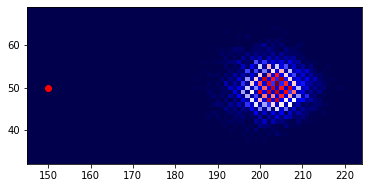

In [13]:
# Plot Density Map

plt.ylim(y_extent_low, y_extent_high) # set y axis to established extent of fallout
plt.xlim(x_extent_low, x_extent_high) # limit x axis to established extent of fallout
plt.imshow(DensityMap, cmap='seismic') # plot density map
plt.scatter(sx, sy, color = "red") # plot marker denoting ground zero as red dot


In [14]:
# FInal statistics
print(settled, "bacteria settled and", lost,  "lost from a colony of", settled + lost,"bacteria, in", timer, "seconds from dispersal time (real time:", run_time, "seconds)")

5000 bacteria settled and 0 lost from a colony of 5000 bacteria, in 80 seconds from dispersal time (real time: 0.9383981227874756 seconds)


In [15]:
stats = np.array([])